# Quantifying a goodness of fit using unbinned likelihood and KS-test

So far in the course we have only used the Chi-squared method to evaluate the goodness of fit. As you recall, for a PDF we could obtain the best parameter values using the unbinned likelihood - but whether it was a good fit we had no way of quantifying. In this excersize we:
1. Find the best parameters using the unbinned likelihood.
2. Use these parameters to obtain a probability using the KS-test.

In this excersize we use simulated diffusion as our model system to apply the method on. 

### References:
- Lectures on Hypothesis testing

### Authors: 
- Mathias L. Heltberg (Niels Bohr Institute)

### Date:    
- 29-12-2021 (latest update)

***

As always we will include a collection of libraries (Standard)

In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
from numpy.linalg import matrix_power                  # This is to raise matrices to powers
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy import stats
from scipy.stats import ks_2samp

Naturally we will here need a random generator:

In [2]:
r = np.random # Random generator
r.seed(42)    # Set a random seed (but a fixed one)

We now simulate a diffusing particle in 2 dimensions. The PDF is given by:

p(r) = r/(2Dt)*exp(-r^2/(4Dt))

We simulate 1000 of these translocations:


In [137]:
def Diffusion(rd,sig):
    return(rd/(sig)*np.exp(-rd**2/(2*sig)))

sig = 1.0;
sig_Cheat = 10.0;
pcheat = 0.1
Npoints = 100
r1 = np.zeros(Npoints)
for i in range(Npoints):
    if (np.random.random() <= 1-pcheat):
        x = np.random.normal()*np.sqrt(sig)
        y = np.random.normal()*np.sqrt(sig)
    else:
        x = np.random.normal()*np.sqrt(sig_Cheat)
        y = np.random.normal()*np.sqrt(sig_Cheat)
    r1[i] = np.sqrt(x**2 + y**2)

And we plot this:

Text(0, 0.5, 'PDF value')

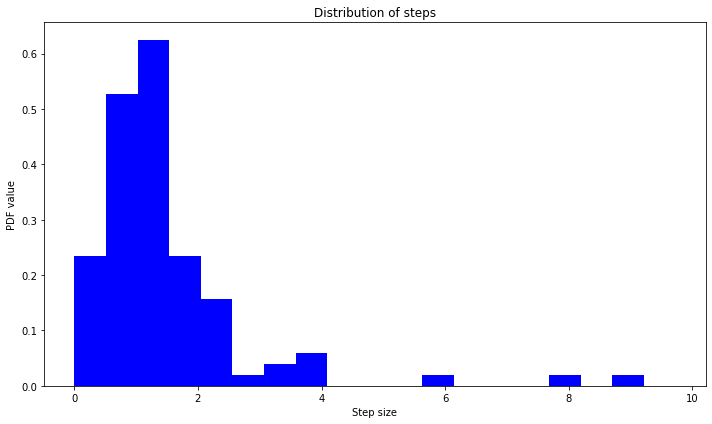

In [138]:
plt.figure(figsize=(10,6), tight_layout=True)
bins = np.linspace(0,np.max(r1)*1.1,20)
plt.hist(r1, bins=bins, color='b', linewidth=4,density=True)
plt.title('Distribution of steps')
plt.xlabel('Step size')
plt.ylabel('PDF value')

Lets use the unbinned likelihood to determine the best parameters:

In [150]:
def min_Diff(sig):
    A = Diffusion(r1,sig)
    return np.sum(-np.log(A))


In [140]:
m_nll = Minuit(min_Diff,sig=1.0)
m_nll.errordef = 0.5
m_nll.migrad()
print("sig = ",m_nll.values[0],", error = ",m_nll.errors[0])


sig =  2.006667501324922 , error =  0.20048244358883285


Text(0, 0.5, 'PDF value')

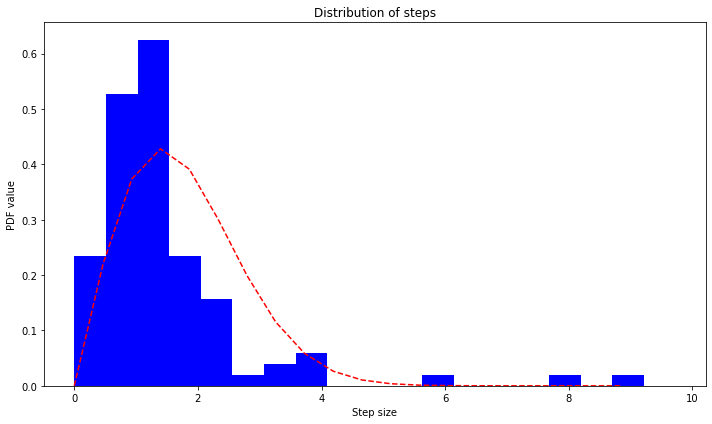

In [141]:
plt.figure(figsize=(10,6), tight_layout=True)
bins = np.linspace(0,np.max(r1)*1.1,20)
plt.hist(r1, bins=bins, color='b', linewidth=4,density=True)
plt.plot(np.linspace(0,np.max(r1),20),Diffusion(np.linspace(0,np.max(r1),20),m_nll.values[0]),'--r')
plt.title('Distribution of steps')
plt.xlabel('Step size')
plt.ylabel('PDF value')

This means that now we can simulate the process again with the best value for sigma (note this might take some seconds to sinulate):

In [155]:
sig = m_nll.values[0];
Ntest = 100
pstat = np.zeros(Ntest)
Nstep = 10000
click = 0;
for test in range(Ntest):
    if (test >= click*10):
        print(test)
        click+=1
    r2 = np.zeros(Nstep)
    for i in range(Nstep):
        x = np.random.normal()*np.sqrt(sig)
        y = np.random.normal()*np.sqrt(sig)
        r2[i] = np.sqrt(x**2 + y**2)
    stat,pval = ks_2samp(r1, r2)
    pstat[test] = pval


0
10
20
30
40
50
60
70
80
90


Text(0, 0.5, 'PDF value')

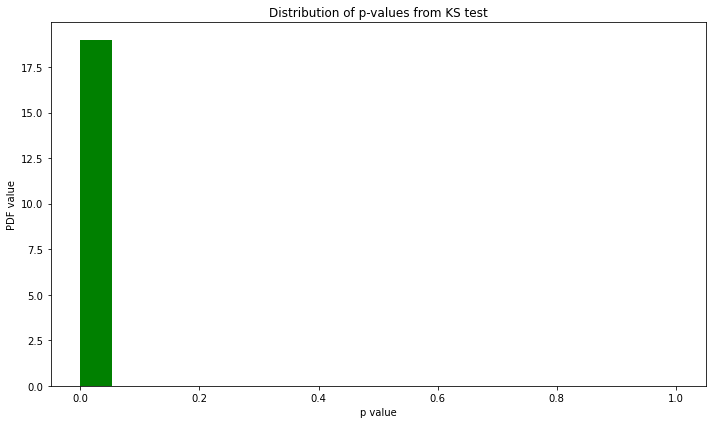

In [152]:
plt.figure(figsize=(10,6), tight_layout=True)
bins = np.linspace(0,1,20)
plt.hist(pstat, bins=bins, color='g', linewidth=4,density=True)
plt.title('Distribution of p-values from KS test')
plt.xlabel('p value')
plt.ylabel('PDF value')

From this we can extract if our unbinned likelihood parameters has a good p-value.

In [153]:
np.mean(pstat)

6.613294213830834e-07

 We can compare the method to the Chi-square:

In [148]:
yExp, xExp_edges = np.histogram(r1, bins=20, range=(0, np.max(r1)))
xExp = (xExp_edges[1:] + xExp_edges[:-1])/2
dx = xExp[1]-xExp[0]
syExp = np.sqrt(yExp)
yNorm = yExp/np.sum(dx*yExp)
syNorm = syExp/np.sum(dx*yExp)
xch = xExp[yExp>0]
ych = yNorm[yNorm>0]
sych = syNorm[yNorm>0]

def chi2_owncalc(sig) :
    y_fit = Diffusion(xch,sig)
    chi2 = np.sum(((ych - y_fit) / sych)**2)
    return chi2   
Minuit.print_level = 1 
miChi2 = Minuit(chi2_owncalc, sig = m_nll.values[0])  
miChi2.errordef = 1.0 
miChi2.migrad()  



┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 13.24                      │              Nfcn = 30               │
│ EDM = 5.89e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ sig  │   0.86    │   0.09    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────┐
│     │     sig │
├─────┼─────────┤
│ sig │ 0.00856 │
└─────┴─────────┘

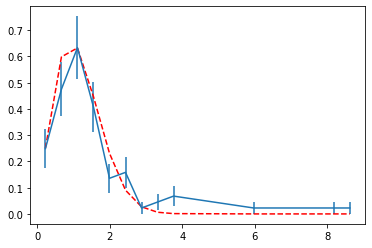

In [149]:
plt.errorbar(xch,ych,sych)
plt.plot(xch,Diffusion(xch,miChi2.values[0]),'--r')

In [146]:
N_NotEmptyBin = np.sum(yExp>0)
Ndof_value = N_NotEmptyBin - miChi2.nfit
chi2_value = miChi2.fval 
Prob_value = stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
print(chi2_value,Ndof_value,Prob_value)

13.243696223588923 11 0.27769645618872596


# Questions:

This exercise is meant to play with the parameters to see when the two methods agree and disagree. Since we want to assign probabilities to our results, it is quite important that probabilities can really be trusted...

1) Start by going through the code. Do you understand what pcheat does? Change pcheat and sig_Cheat and investigate how the probabilities come out for both methods.

2) Investigate (for instance by plotting) the values of the parameter "sig" for both the unbinned likelihood and the Chi Square estimation as a function of Npoints and sig_Cheat. Is there some clear pattern?

### Advanced question:

3) How does the mean and standard deviation of the KS-probability (i.e. pstat) as a function of Nstep?

4) Generate randomly distributed numbers following the PDF directly by using the transformation method (This is one of the examples where it can be done!).